Consider the model of a pendulum
$$
\dot{q} = \begin{bmatrix}
    \dot{\theta} \\
    \dot{\omega} 
\end{bmatrix} = 
\begin{bmatrix} 
    \omega \\
    -\frac{g}{l} \sin(\theta)
\end{bmatrix} = f(q).
$$

In [1]:
from math import sin, pi
import numpy as np
def pendulum_dynamics(q):
    l = 1.0
    g = 9.81
    
    theta = q[0]
    theta_dot = q[1]
    
    theta_ddot = -(g/l)*sin(theta)
    
    return np.array([theta_dot, theta_ddot])

## Forward Euler
$$
\dot{q}(t) \approx \frac{q(t + \Delta t) - q(t)}{\Delta t}
$$
Let $q_k$ and $q_{k+1}$ denote $q(t)$ and $q(t + \Delta t)$, respectively.
$$
\begin{aligned}
    \frac{q_{k+1} - q_k}{\Delta t} &= f(q_k) \\
    q_{k+1} &= q_k + f(q_k) \Delta t 
\end{aligned}
$$


In [2]:
def forward_euler(dyn_fun, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = q_hist[:,k] + dt*dyn_fun(q_hist[:,k])
        
    return q_hist, t

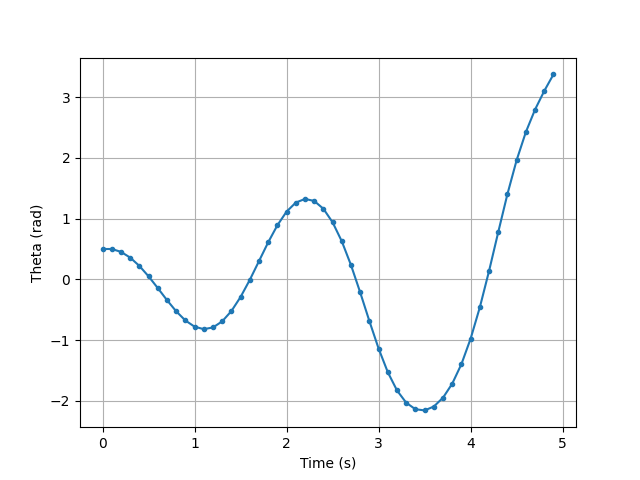

In [3]:
%matplotlib ipympl
import matplotlib.pyplot as plt
q0 = np.array([0.5, 0.])
q_hist, t_hist = forward_euler(pendulum_dynamics,
                               q0,
                               Tf=5,
                               dt=0.1)
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.grid()
plt.show()

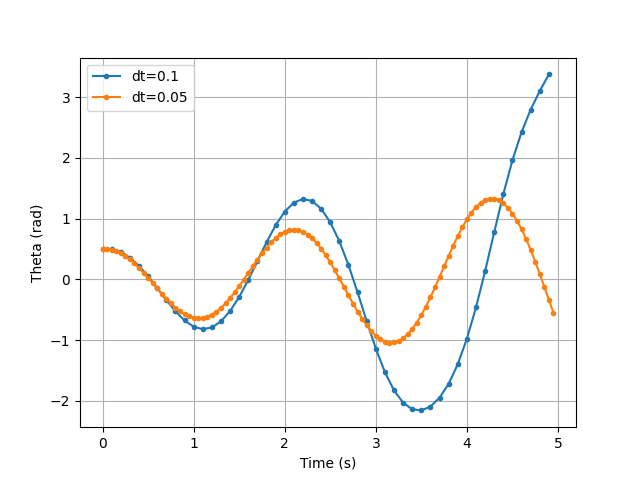

In [4]:
q_hist_1, t_hist_1 = forward_euler(pendulum_dynamics,
                                   q0,
                                   Tf=5,
                                   dt=0.05)
plt.figure()
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="dt=0.05")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

# Runge–Kutta methods

We consider the 4th order Runge-Kutta method (RK4):
$$
\begin{aligned}
    k_1 &= f(q_k) \\
    k_2 &= f(q_k + 0.5 k_1 \Delta t) \\
    k_3 &= f(q_k + 0.5 k_2 \Delta t) \\
    k_4 &= f(q_k + k_3 \Delta t) \\
    q_{k+1} &= q_k + \frac{\Delta t}{6}(k_1 + 2 k_2 + 2 k_3 + k_4) 
\end{aligned}
$$

In [5]:
def fd_pendulum_rk4(qk, dt):
    f1 = pendulum_dynamics(qk)
    f2 = pendulum_dynamics(qk + 0.5*dt*f1)
    f3 = pendulum_dynamics(qk + 0.5*dt*f2)
    f4 = pendulum_dynamics(qk + dt*f3)
    return qk + (dt/6.0)*(f1 + 2*f2 + 2*f3 + f4)

def RK4(dyn_fun, q0, Tf, dt):
    t = np.arange(0, Tf, dt)
    num_points = len(t)
    dim_x = len(q0)
    q_hist = np.zeros((dim_x, num_points))
    q_hist[:,0] = q0
    
    for k in range(num_points-1):
        q_hist[:,k+1] = fd_pendulum_rk4(q_hist[:,k], dt)

    return q_hist, t

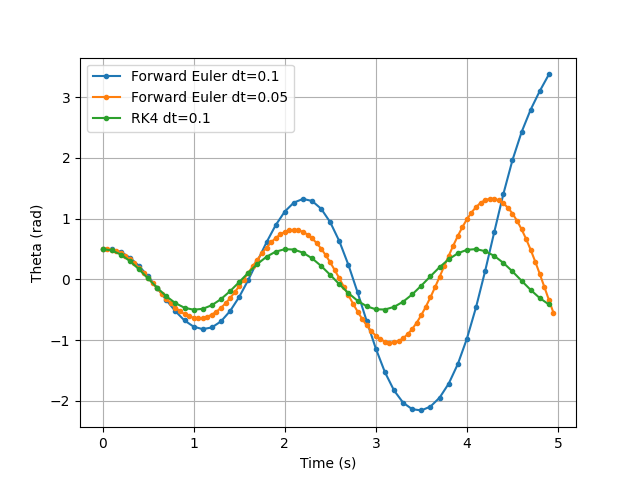

In [6]:
q_hist_rk, t_hist_rk = RK4(pendulum_dynamics, 
                           q0,
                           Tf=5,
                           dt=0.1)
plt.figure()
plt.plot(t_hist, q_hist[0,:], "-o", markersize=3, label="Forward Euler dt=0.1")
plt.plot(t_hist_1, q_hist_1[0,:], "-o", markersize=3, label="Forward Euler dt=0.05")
plt.plot(t_hist_rk, q_hist_rk[0,:], "-o", markersize=3, label="RK4 dt=0.1")
plt.xlabel("Time (s)")
plt.ylabel("Theta (rad)")
plt.legend()
plt.grid()
plt.show()

# What's next?
- Semi-implicit Euler

- Implicit integration

- Collocation-based integration